# CS767 TERM PROJECT

## Rohan J Aditya (U17792248)

### Boston University 
### Spring 2022

In [1]:
import pandas as pd
import numpy as np

import re
import contractions
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, TimeDistributed, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import time

plt.style.use("default")
warnings.filterwarnings("ignore")

### Versions of packages used

* NumPy: 1.21.5
* Pandas: 1.4.2
* NLTK: 3.2
* TensorFlow GPU: 2.6.0
* Seaborn: 0.11.2

## Data Set Source

https://www.kaggle.com/datasets/sbhatti/news-summarization

# Preprocessing

The following preprocessing tasks are performed on the data set:

* Drop NULL values
* Drop duplicate rows
* Expand contractions
* Remove HTML tags
* Remove non alphabet characters
* Remove extra whitespaces
* Remove stop words
* Remove short words

In [2]:
# Function to preprocess a list of sentences
def text_preprocess(text_list):
    
    # Expand contractions
    text_list = [contractions.fix(sentence) for sentence in text_list]
    # Remove HTML tags
    text_list = [BeautifulSoup(sentence, "html.parser").get_text() for sentence in text_list]
    # Keep only alphabet characters and whitespaces
    text_list = [re.sub(r"[^a-zA-Z\s]", " ", sentence).lower() for sentence in text_list]
    # Remove \n
    text_list = [re.sub(r"\n", "", sentence) for sentence in text_list]
    # Remove extra whitespaces
    text_list = [re.sub(" +", " ", sentence) for sentence in text_list]
    # Remove stop words and short words
    text_list = [[word for word in sentence.split() if not word in stopwords.words("english") and len(word)>=3] 
                 for sentence in text_list]
    text_list = [" ".join(sentence) for sentence in text_list]
    
    return text_list

In [3]:
# Function to clean and preprocess the dataframe containing the content and summaries
def clean_data():
    
    df = pd.read_csv("data.csv")
    
    df = df[['Content', 'Summary', 'Dataset']]
    
    # Drop null values
    df = df.dropna().reset_index(drop=True)
    
    # Drop duplicate rows
    df = df.drop_duplicates(subset=['Content', 'Summary']).reset_index(drop=True)
    
    # Clean content text
    cont = text_preprocess(df['Content'])
    # Clean summary text
    summ = text_preprocess(df['Summary'])
    
    df_clean = pd.DataFrame({'Content':cont, 'Summary':summ})
    
    # Sentence lengths of Content and Summary
    len_c = np.array([len(x.split()) for x in df_clean['Content']])
    len_s = np.array([len(x.split()) for x in df_clean['Summary']])
    
    '''
    Rows which satifsy any one of the following conditions are removed:

        1. Length of the Content sentence is less than that of the Summary sentence
        2. Length of the Content sentence is less than or equal to 15
        3. Length of the Content sentence is greater than or equal to 2500
        4. Length of the Summary sentence is less than or equal to 10
        5. Length of the Summary sentence is greater than or equal to 15
    '''
    
    flag_1 = len_c > len_s
    flag_2 = len_c > 15
    flag_3 = len_c < 2500
    flag_4 = len_s > 10
    flag_5 = len_s < 250

    df_clean = df_clean.iloc[np.where(flag_1 & flag_2 & flag_3 & flag_4 & flag_5)[0]]
    df_clean.reset_index(inplace=True, drop=True)
    
    # START and END tokens are added to the Summary sentences for the decoder
    df_clean['Summary_clean'] = ["<START> " + sentence + " <END>" for sentence in df_clean['Summary']]
    
    # Save the clean CSV file
    df_clean.to_csv("data_clean.csv", index=False)
    
    return df_clean

In [4]:
if "data_clean.csv" not in os.listdir(): 
    df = clean_data()
    df = df.drop_duplicates().reset_index(drop=True)
    
else:
    df = pd.read_csv("data_clean.csv")
    df = df.drop_duplicates().reset_index(drop=True)

In [5]:
df.tail()

,Content,Summary,Summary_clean
515052,rabbis mendel epstein martin wolmark asked hir...,two new jersey rabbis arrested charged plottin...,_START_ two new jersey rabbis arrested charged...
515053,nigeria football federation nff wants avoid di...,nigeria players understand wait paid outstandi...,_START_ nigeria players understand wait paid o...
515054,discouraging start began two defeats draw conc...,charlton earned first victory season first new...,_START_ charlton earned first victory season f...
515055,first study kind charts theft fraud misuse mon...,one five older people northern ireland affecte...,_START_ one five older people northern ireland...
515056,day year old man miraculously survived suicide...,rescuers niagara falls still found body man ju...,_START_ rescuers niagara falls still found bod...


# EDA

Here, we look at the distribution of the lengths of the content and summary to get an idea of what to set as the maximum content length and maximum summary length

In [6]:
len_c = np.array([len(x.split()) for x in df['Content']])
len_s = np.array([len(x.split()) for x in df['Summary']])

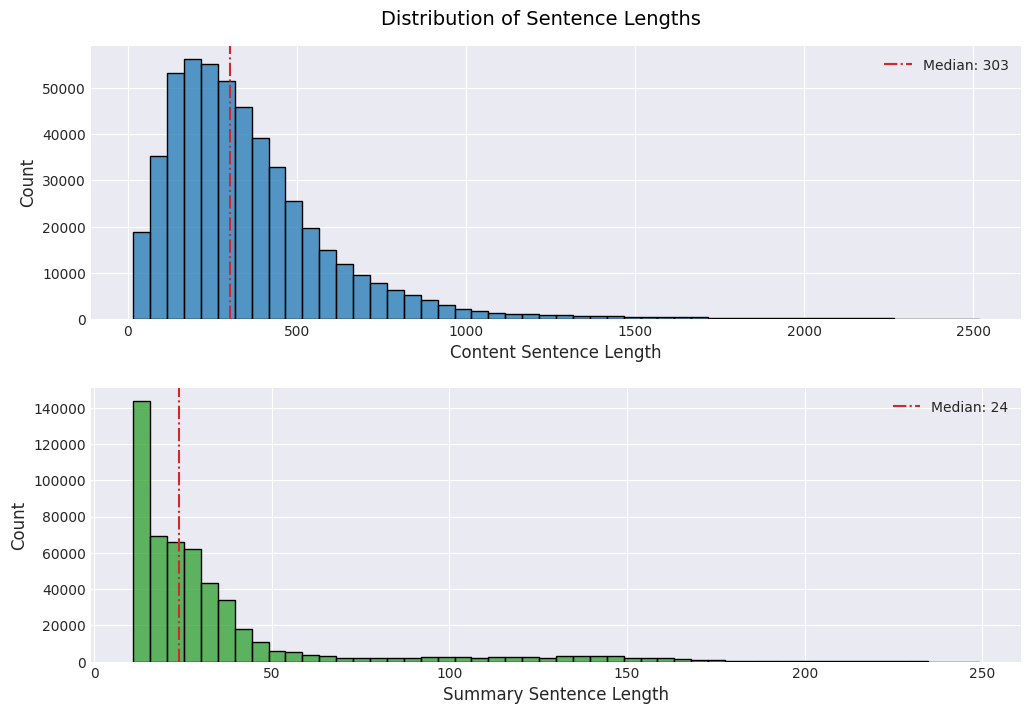

In [7]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), dpi=100)
    sns.histplot(data=len_c, ax=ax[0], binwidth=50, color='tab:blue');
    sns.histplot(data=len_s, ax=ax[1], bins=50, color='tab:green');
    
    ax[0].set_ylabel("Count", fontsize=12)
    ax[1].set_ylabel("Count", fontsize=12)
    ax[0].set_xlabel("Content Sentence Length", fontsize=12)
    ax[1].set_xlabel("Summary Sentence Length", fontsize=12)
    
    ax[0].axvline(np.median(len_c), linestyle="-.", color='tab:red', label='Median: {:d}'.format(int(np.median(len_c))))
    ax[1].axvline(np.median(len_s), linestyle="-.", color='tab:red', label='Median: {:d}'.format(int(np.median(len_s))))
    
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    
plt.suptitle("Distribution of Sentence Lengths", fontsize=14, y=0.925);
plt.subplots_adjust(hspace=0.25);

In [8]:
print("Content:")
print("\tMean Length: {:.2f}".format(np.mean(len_c)))
print("\tMedian Length: {:.2f}".format(np.median(len_c)))
print("\nSummary:")
print("\tMean Length: {:.2f}".format(np.mean(len_s)))
print("\tMedian Length: {:.2f}".format(np.median(len_s)))

Content:
	Mean Length: 368.12
	Median Length: 303.00

Summary:
	Mean Length: 34.01
	Median Length: 24.00


# Model

We will set the maximum content length as 400 and maximum summary length as 25 to get a balance between the size of the input data and reduction of the number of input tuples

In [9]:
max_len_content = 400
max_len_summary = 25

In [10]:
# Remove the rows which fall outside the set maximum lengths of the content and summary
df = df.iloc[np.where(np.logical_and(len_c<=max_len_content, len_s<=max_len_summary))[0]].reset_index(drop=True)

In [11]:
df.tail()

,Content,Summary,Summary_clean
231710,government bill got senate approval votes supp...,australia passed controversial security law re...,_START_ australia passed controversial securit...
231711,olympic super heavyweight champion says suffer...,audley harrison retired boxing second time rev...,_START_ audley harrison retired boxing second ...
231712,rabbis mendel epstein martin wolmark asked hir...,two new jersey rabbis arrested charged plottin...,_START_ two new jersey rabbis arrested charged...
231713,nigeria football federation nff wants avoid di...,nigeria players understand wait paid outstandi...,_START_ nigeria players understand wait paid o...
231714,first study kind charts theft fraud misuse mon...,one five older people northern ireland affecte...,_START_ one five older people northern ireland...


In [12]:
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df[['Content']],
                                                                df[['Summary_clean']],
                                                                test_size=0.1,
                                                                random_state=767, 
                                                                shuffle=True)

df_x_train, df_x_val, df_y_train, df_y_val = train_test_split(df_x_train, 
                                                              df_y_train, 
                                                              test_size=0.1, 
                                                              random_state=767,
                                                              shuffle=True)

In [13]:
x_train = df_x_train["Content"].values
x_val = df_x_val["Content"].values
x_test = df_x_test["Content"].values

y_train = df_y_train["Summary_clean"].values
y_val = df_y_val["Summary_clean"].values
y_test = df_y_test["Summary_clean"].values

In [14]:
print("Shape of training set:", x_train.shape)
print("Shape of validation set:", x_val.shape)
print("Shape of test set:", x_test.shape)

Shape of training set: (187688,)
Shape of validation set: (20855,)
Shape of test set: (23172,)


### Tokenizing the content text

In [15]:
st = time.time()

tokenizer_content = Tokenizer()
tokenizer_content.fit_on_texts(x_train);

x_train = tokenizer_content.texts_to_sequences(x_train)
x_val = tokenizer_content.texts_to_sequences(x_val)
x_test = tokenizer_content.texts_to_sequences(x_test)

x_train= pad_sequences(x_train,  maxlen=max_len_content, padding='post')
x_val = pad_sequences(x_val,  maxlen=max_len_content, padding='post')
x_test = pad_sequences(x_test,  maxlen=max_len_content, padding='post')

et = time.time()
print("Time taken: {:d} h {:d} min {:.2f} s".format(int((et - st)/3600), int(((et - st)%3600)/60), ((et - st)%3600)%60))

Time taken: 0 h 0 min 33.90 s


### Tokenizing the summary text

In [16]:
st = time.time()

tokenizer_summary = Tokenizer()
tokenizer_summary.fit_on_texts(y_train);

y_train = tokenizer_summary.texts_to_sequences(y_train)
y_val = tokenizer_summary.texts_to_sequences(y_val)
y_test = tokenizer_summary.texts_to_sequences(y_test)

y_train= pad_sequences(y_train,  maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val,  maxlen=max_len_summary, padding='post')
y_test = pad_sequences(y_test,  maxlen=max_len_summary, padding='post')

et = time.time()
print("Time taken: {:d} h {:d} min {:.2f} s".format(int((et - st)/3600), int(((et - st)%3600)/60), ((et - st)%3600)%60))

Time taken: 0 h 0 min 5.77 s


In [17]:
# Sizes of x and y vocabularies
x_voc = len(tokenizer_content.word_index) + 1
y_voc = len(tokenizer_summary.word_index) + 1

print("Size of x vocab: ", x_voc, "\nSize of y vocab: ",y_voc)

Size of x vocab:  290802 
Size of y vocab:  84969


### Encoder

In [18]:
lstm_units = 800
embedding_units = 500

# Encoder Input Layer
encoder_input = Input(shape=(max_len_content,))

# Encoder Embedding Layer
encoder_embedding = Embedding(x_voc, embedding_units, trainable=True, name="encoder_emb")(encoder_input)

# Encoder LSTM 1
encoder_lstm1 = LSTM(lstm_units, return_sequences=True, return_state=True, name="encoder_lstm1")
encoder_layer1, state_a1, state_c1 = encoder_lstm1(encoder_embedding)

# Encoder LSTM 2
encoder_lstm2 = LSTM(lstm_units, return_sequences=True, return_state=True, name="encoder_lstm2")
encoder_layer2, state_a2, state_c2 = encoder_lstm2(encoder_layer1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(lstm_units, return_sequences=True, return_state=True, name="encoder_lstm3")
encoder_layer_last, state_a_last, state_c_last = encoder_lstm3(encoder_layer2)

### Decoder

In [19]:
# Decoder Input Layer
decoder_input = Input(shape=(None,))

# Decoder Embedding
decoder_embedding = Embedding(y_voc, embedding_units, trainable=True, name="decoder_emb")
decoder_emb_layer = decoder_embedding(decoder_input)

# Decoder LSTM
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_layer, decoder_state_f, decoder_state_b = decoder_lstm(decoder_emb_layer, initial_state=[state_a_last, state_c_last])

# Attention Layer
attention = Attention()
attention_layer = attention([decoder_layer, encoder_layer_last])

# Decoder Concatenate Layer
decoder_concat = Concatenate(axis=-1)([decoder_layer, attention_layer])

# Decoder Dense Layer
decoder_dense = TimeDistributed(Dense(y_voc, activation="softmax"))
decoder_output = decoder_dense(decoder_concat)

In [20]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)

# Model Checkpoint
model_path = "/Weights/model_weight_checkpoint.h5"
model_checkpoint = ModelCheckpoint(filepath=model_path, save_weights_only=True ,save_best_only=True, monitor='val_loss', mode='min')

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
encoder_emb (Embedding)         (None, 400, 500)     145401000   input_1[0][0]                    
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 400, 800), ( 4163200     encoder_emb[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Training

The model was trained in Google Colab and the weights were saved as *model_weights.h5*

Training took almost 13 hours. So the best weights are provided with the submission

A screenshot of the losses for each epoch and the loss plot were taken from Colab and given below

If the model should be trained again, change the value of *to_train* in the below cell to `True`

Check whether the model weights that were trained already can be used

If so, load those model weights. Otherwise, train the model again

In [22]:
# Flag to control whether or not the model should be trained again
to_train = False

In [23]:
if "model_weights.h5" in os.listdir() and len(x_train)==187688 and model.count_params()== 342493669 and len(model.layers)==11 and not to_train:
    model.load_weights("model_weights.h5")

else:
    history = model.fit(x=[x_train, y_train[:,:-1]], 
                        y=y_train.reshape(-1, max_len_summary, 1)[:,1:], 
                        validation_data=([x_val, y_val[:,:-1]], y_val.reshape(-1, max_len_summary, 1)[:,1:]), 
                        epochs=25, 
                        callbacks=[early_stopping, model_checkpoint])
    
    fig, ax = plt.subplots(1, 1, figsize=(7.2,4.8), dpi=100)
    ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="Train Loss")
    ax.plot(range(1, len(history.history['loss'])+1),history.history['val_loss'], label="Val Loss")
    ax.set_title("Train and Validation Losses", fontsize=14, pad=10)
    ax.set_xlabel("Epoch", fontsize=12, labelpad=10)
    ax.set_ylabel("Loss", fontsize=12, labelpad=10)
    ax.legend(loc="best")
    ax.grid(linestyle=":", alpha=0.25);
    plt.savefig("epoch loss plot.png")
    
    model.save_weights("model_weights.h5")

### History of the model trained on Colab

The following plots show the history of the model trained on Colab. The best weights of the model after this training were saved and are included in the submission with the file name *model_weights.h5*

Train and Val losses for each epoch


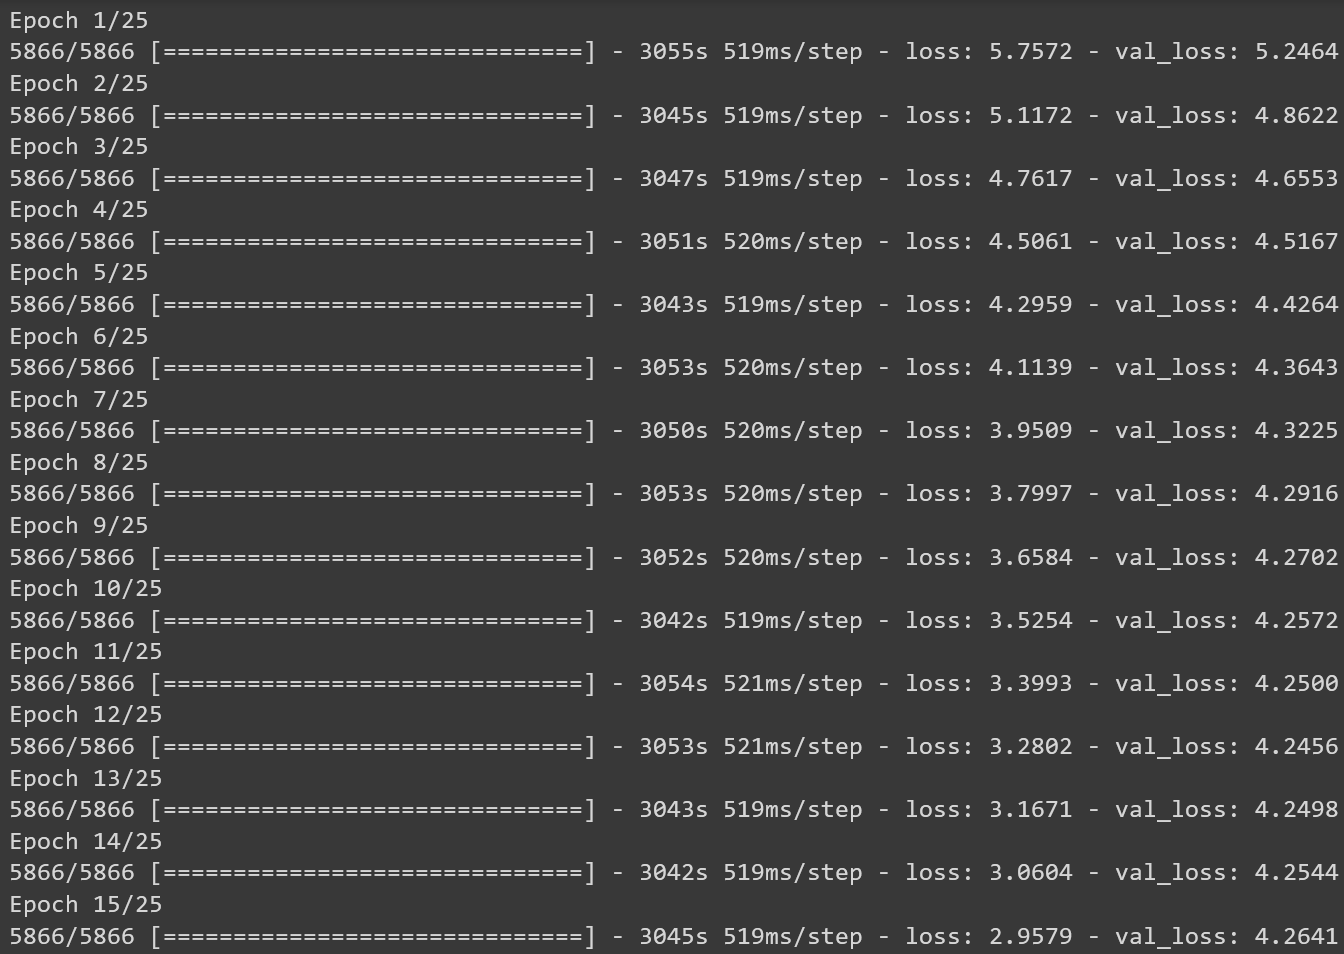

In [24]:
from IPython.display import Image
print("Train and Val losses for each epoch")
Image(filename="epoch-losses.png",width=800, height=400)

Train and Val losses for each epoch


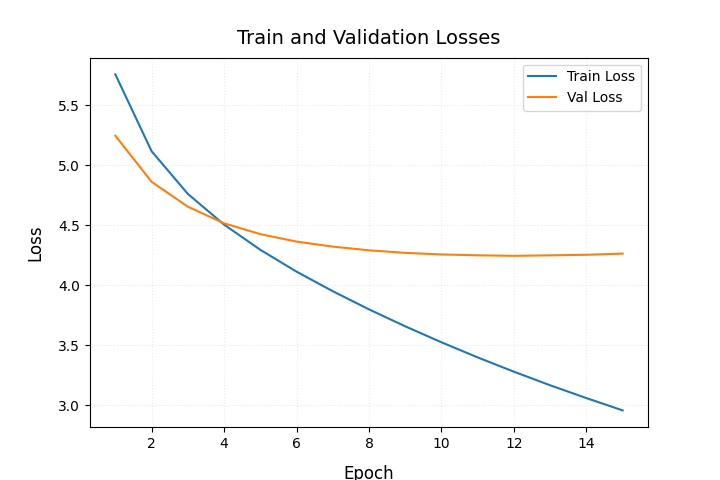

In [25]:
print("Train and Val losses for each epoch")
Image(filename="epoch loss plot.png",width=800, height=400)

### Inference

In [26]:
# Inputs and Outputs of the Encoder
encoder_model = Model(inputs=[encoder_input], outputs=[encoder_layer_last, state_a_last, state_c_last])

inference_decoder_input = Input(shape=(max_len_content, lstm_units))
decoder_input_a = Input(shape=(lstm_units,))
decoder_input_c = Input(shape=(lstm_units,))

inference_decoder_emb = decoder_embedding(decoder_input)

inference_decoder_layer, inf_state_a, inf_state_c = decoder_lstm(inference_decoder_emb, 
                                                         initial_state=[decoder_input_a, decoder_input_c])

inference_attention = attention([inference_decoder_layer, inference_decoder_input])
inference_concat = Concatenate()([inference_decoder_layer, inference_attention])

inference_decoder_output = decoder_dense(inference_concat)

In [27]:
inference_model = Model([decoder_input] + [inference_decoder_input, decoder_input_a, decoder_input_c], 
                        [inference_decoder_output] + [inf_state_a, inf_state_c])

## Make Predictions

In [28]:
# Dictionary of index and word of content and summary
index_word_content = tokenizer_content.index_word
index_word_summary = tokenizer_summary.index_word

# dictionary of word and index of content and summary
word_index_content = tokenizer_content.word_index
word_index_summary = tokenizer_summary.word_index

In [29]:
# Function to predict the summary sentence (preprocessed version) given input tokens
def predict_summary(input_tokens):
    
    encoder_output, encoder_state_a, encoder_state_c = encoder_model.predict(input_tokens)
    
    decoder_input_token = np.array([[word_index_summary['start']]])
    
    flag = False
    pred_sentence = "start"
    
    while not flag:
        inference_output, inference_a, inference_c = inference_model.predict([decoder_input_token] + [encoder_output, encoder_state_a, encoder_state_c])
        
        token_idx = np.argmax(inference_output.ravel())
        pred_word = index_word_summary[token_idx]
        
        if pred_word != 'end':
            pred_sentence = pred_sentence + " " + pred_word
            
        if pred_word == "end" or len(pred_sentence.split()) >= max_len_summary:
            pred_sentence = pred_sentence + " end"
            flag = True
            
        decoder_input_token = np.array([[token_idx]])
        
        encoder_state_a = inference_a
        encoder_state_c = inference_c
    
    return pred_sentence

It took around 6 hours on Colab to make predictions for all the test sentences. Therefore, the predicted sentences are given as CSV files. We check if they are present in the directory. If so, they are loaded as dataframes. Otherwise, predictions are made again.

The predictions are broken up so that they wouldn't be lost if the Colab runtime got disconnected.

In [30]:
if "pred_sen1.csv" not in os.listdir():
    st = time.time()
    pred_sentences = [predict_summary(x_test[i].reshape(1,-1))[6:-4] for i in range(8000)]
    et = time.time()
    print("Time taken: {:d} h {:d} min {:.2f} s".format(int((et - st)/3600), int(((et - st)%3600)/60), ((et - st)%3600)%60))
    p1 = pd.DataFrame(pred_sentences)
    p1.to_csv("pred_sen1.csv", index=False)

else:
    p1 = pd.read_csv("pred_sen1.csv")

if "pred_sen2.csv" not in os.listdir():
    st = time.time()
    pred_sentences = [predict_summary(x_test[i].reshape(1,-1))[6:-4] for i in range(8001,16000)]
    et = time.time()
    print("Time taken: {:d} h {:d} min {:.2f} s".format(int((et - st)/3600), int(((et - st)%3600)/60), ((et - st)%3600)%60))
    p2 = pd.DataFrame(pred_sentences)
    p2.to_csv("pred_sen2.csv", index=False)
    
else:
    p2 = pd.read_csv("pred_sen2.csv")
    
if "pred_sen3.csv" not in os.listdir():
    st = time.time()
    pred_sentences = [predict_summary(x_test[i].reshape(1,-1))[6:-4] for i in range(16001,len(x_test))]
    et = time.time()
    print("Time taken: {:d} h {:d} min {:.2f} s".format(int((et - st)/3600), int(((et - st)%3600)/60), ((et - st)%3600)%60))
    p3 = pd.DataFrame(pred_sentences)
    p3.to_csv("pred_sen3.csv", index=False)

else:
    p3 = pd.read_csv("pred_sen3.csv")

In [31]:
pred_sentences = pd.concat([p1, p2, p3])['0'].tolist()

In [32]:
# Convert actual tokenized test summaries into text
st = time.time()
summ_sentences = [tokenizer_summary.sequences_to_texts([y_test[i]])[0][6:-4] for i in range(8000)]
et = time.time()
print("Time taken: {:d} h {:d} min {:.2f} s".format(int((et - st)/3600), int(((et - st)%3600)/60), ((et - st)%3600)%60))

Time taken: 0 h 0 min 0.06 s


# Evaluation

In [33]:
# ROUGE Scorer
scorer_rouge = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)

In [34]:
# Function to compare the content text, summary text, and predicted summary text for individual test samples
def compare_summ(idx):
    act_cont = tokenizer_content.sequences_to_texts([x_test[idx]])[0]
    act_sum = tokenizer_summary.sequences_to_texts([y_test[idx]])[0][6:-4]
    pred_sum = predict_summary(x_test[idx].reshape(1,-1))[6:-4]
    print("Actual Content:\n", act_cont)
    print("\nActual Summary:\n", act_sum)
    print("\nPredicted Summary:\n", pred_sum)
    print("\nBLEU Score: {:.4f}".format(sentence_bleu([act_sum.split()], pred_sum.split())))
    print("\nROUGE-1 f1 Score: {:.4f}".format(scorer_rouge.score(act_sum, pred_sum)['rouge1'][-1]))
    print("\nROUGE-L f1 Score: {:.4f}".format(scorer_rouge.score(act_sum, pred_sum)['rougeL'][-1]))
    

In [35]:
compare_summ(92)

Actual Content:
 bus drivers weymouth bridport involved ninth week strike action first dorset said unite union wanted reserve right vote arbitrator binding decision however unite said members union wanted right vote trust bus firm marc reddy managing director first dorset said arbitration logical sensible means bringing dispute end encouraged union finally showed willingness enter process however prospect settlement binding arbitration question union gets act together unite regional officer bob lanning said refused sign paper first dorset agreeing union would adhere arbitrator acas decision branding unnecessary know arbitration binding members demanding vote decision trust first said added members suspicious firm wanted piece paper signing addition terms reference arbitration third party makes ruling members want vote would lose support members public unite said weymouth bridport drivers earn hour want rise three years match wages drivers yeovil somerset first dorset said increase unaf

## BLEU Score

In [36]:
bleu_scores = [sentence_bleu([summ_sentences[i].split()], pred_sentences[i].split()) for i in range(len(summ_sentences))]

In [37]:
print("Mean BLEU Score: {:.4f}".format(np.mean(bleu_scores)))

Mean BLEU Score: 0.3058


## ROUGE Scores

In [38]:
r1_f = []
rL_f = []

for i in range(len(summ_sentences)):
    rouge_scores = scorer_rouge.score(summ_sentences[i], pred_sentences[i])
    rouge1 = np.array(rouge_scores['rouge1'])
    rougeL = np.array(rouge_scores['rougeL'])
    
    r1_f.append(rouge1[-1])
    rL_f.append(rougeL[-1])

In [39]:
print("Mean ROUGE-1 f1 Score: {:.4f}".format(np.mean(r1_f)))
print("Mean ROUGE-L f1 Score: {:.4f}".format(np.mean(rL_f)))

Mean ROUGE-1 f1 Score: 0.1288
Mean ROUGE-L f1 Score: 0.1124


## Validation Metrics

In [40]:
pd.DataFrame([[np.mean(bleu_scores), np.mean(r1_f), np.mean(rL_f)]], columns=["BLEU", "ROUGE-1 F-1", "ROUGE-L F-1"])

,BLEU,ROUGE-1 F-1,ROUGE-L F-1
0,0.305753,0.128793,0.112402
